In [1]:
import torch
from encoder.encoders import DistributionEncoderTx
from generator.wormhole import WormholeGenerator
from datasets.distribution_datasets import NormalDistributionDataset
from torch.utils.data import DataLoader
from generator.losses import pairwise_sinkhorn, sink_D_batched

import seaborn as sns
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)

In [2]:
set_size = 100
dataset = NormalDistributionDataset(n_sets=10**5, data_shape=(2,), set_size=set_size)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)

In [3]:
in_dim = 2
latent_dim = 16
hidden_dim = 128
device = 'cuda'

enc = DistributionEncoderTx(in_dim, latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device);

In [4]:
for idx,batch in enumerate(dataloader):
    
    samples = batch['samples'].flatten(start_dim=2).to(device)
    latent = enc(samples)
    loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if idx % 100 == 0:
        print(idx, loss.item())

0 1.5571171045303345
100 0.5652108192443848
200 0.37248629331588745
300 0.5661506652832031
400 0.2671888470649719
500 0.13017523288726807
600 0.15985113382339478
700 0.1283777803182602
800 0.12200874090194702
900 0.09448389708995819
1000 0.27124205231666565
1100 0.09382382035255432
1200 0.060529548674821854
1300 0.0910813957452774
1400 0.04209936410188675
1500 0.43025490641593933
1600 0.05696740373969078


KeyboardInterrupt: 

In [5]:
enc.eval()
gen.eval()

n_points = 100


with torch.no_grad():
    samples = dataset.data[:n_points]
    mu, var = dataset.mu[:n_points], dataset.var[:n_points]
    W = dataset.wasserstein_distance(mu, var)

    samples = torch.tensor(samples, dtype=torch.float).to(device)
    latent = enc(samples.flatten(start_dim=2))

    L2 = torch.cdist(latent, latent)

    S2 = pairwise_sinkhorn(samples.flatten(start_dim=2))

Text(0, 0.5, 'Wasserstein distance')

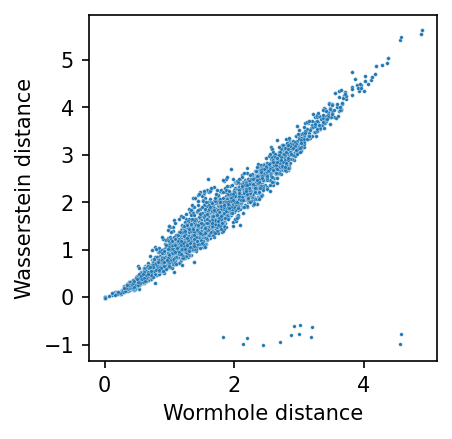

In [8]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=L2.flatten().cpu(), y=S2.flatten().cpu(), s=3)
plt.xlabel('Wormhole distance')
plt.ylabel('Sinkhorn')

Text(0, 0.5, 'Wasserstein distance')

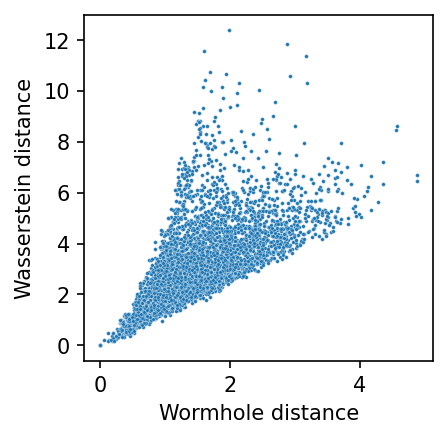

In [6]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=L2.flatten().cpu(), y=W.flatten(), s=3)
plt.xlabel('Wormhole distance')
plt.ylabel('Wasserstein distance')

Text(0.5, 0, 'Wasserstein distance')

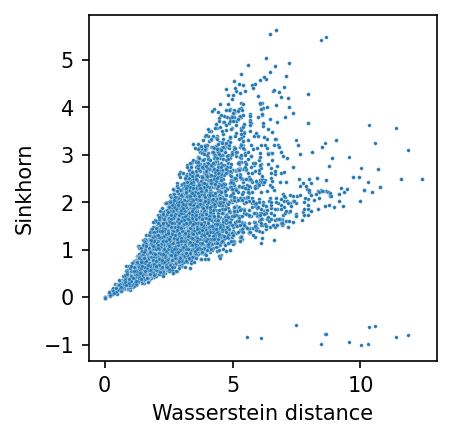

In [7]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=W.flatten(), y=S2.flatten().cpu(), s=3)
plt.ylabel('Sinkhorn')
plt.xlabel('Wasserstein distance')